# hypopy tutorial, P-wave arrivals only

## Outline

- [Create synthetic data](#Create-synthetic-data)
- [Initial hypocenter locations](#Initial-hypocenter-locations)
- [Velocity data points](#Velocity-data-points)
- [Calibration shots](#Calibration-shots)
- [Constant velocity inversion](#Constant-velocity-inversion)
- [Joint hypocenter-velocity inversion parameters](#Joint-hypocenter-velocity-inversion-parameters)
- [Joint hypocenter-velocity inversion](#Joint-hypocenter-velocity-inversion)
- [Results](#Results)


In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import hypo

## Create first synthetic data

Define limits and build grid

In [2]:
xmin = 90.0
xmax = 211.0
ymin = 80.0
ymax = 211.0
zmin = 0.0
zmax = 101.0

dx = 5.0   # grid cell size, we use cubic cells here

x = np.arange(xmin, xmax, dx)
y = np.arange(ymin, ymax, dx)
z = np.arange(zmin, zmax, dx)

g = hypo.Grid3D(x, y, z)

We need some receivers

In [3]:
rcv = np.array([[112., 115., 13.],
                [111., 116., 40.],
                [111., 113., 90.],
                [151., 117., 17.],
                [180., 115., 16.],
                [113., 145., 11.],
                [160., 150., 17.],
                [185., 149., 15.],
                [117., 184., 11.],
                [155., 192.,  9.],
                [198., 198., 10.],
                [198., 196., 40.],
                [198., 193., 90.]])
ircv = np.arange(rcv.shape[0]).reshape(-1,1)   # vector of rcv indices
nsta = rcv.shape[0]

Let's create 15 events randomly located in the grid

In [4]:
nev = 15
src = np.vstack((np.arange(nev),                                            # event ID
                 np.linspace(0., 50., nev) + np.random.randn(nev),          # origin time
                 160. + 10.*np.random.randn(nev),                           # x
                 140. + 10.*np.random.randn(nev),                           # y
                  60. + 10.*np.random.randn(nev))).T                        # z

h_true = src.copy()

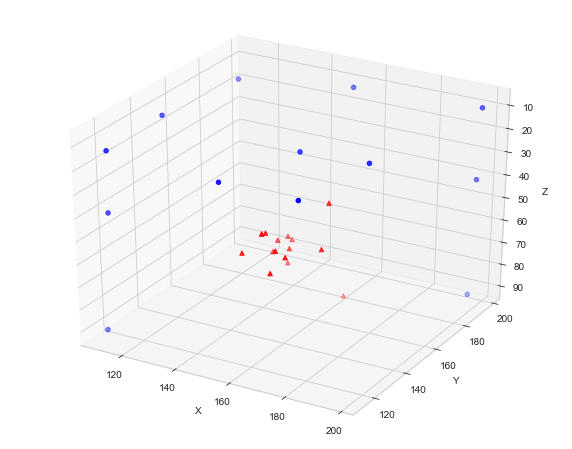

In [5]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rcv[:,0], rcv[:,1], rcv[:,2], c='b', marker='o')
ax.scatter(src[:,2], src[:,3], src[:,4], c='r', marker='^')
ax.invert_zaxis()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

For simplicity, we will use a velocity model with a small vertical gradient and mean Vp = 4000 m/s

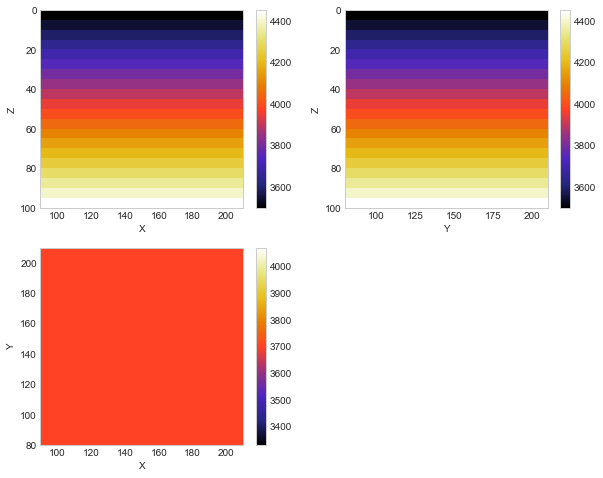

In [6]:
def Vz(z):
    return 4000.0 + 10.0*(z-50.0)
Vp = np.kron(Vz(z), np.ones((g.shape[0], g.shape[1], 1)))

plt.figure(figsize=(10,8))
plt.subplot(221)
plt.pcolor(x,z,np.squeeze(Vp[:,0,:].T), cmap='CMRmap',), plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Z')
plt.colorbar()
plt.subplot(222)
plt.pcolor(y,z,np.squeeze(Vp[0,:,:].T), cmap='CMRmap'), plt.gca().invert_yaxis()
plt.xlabel('Y')
plt.ylabel('Z')
plt.colorbar()
plt.subplot(223)
plt.pcolor(x,y,np.squeeze(Vp[:,:,4].T), cmap='CMRmap')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()

plt.show()

Let's now compute the travel times

The raytracing routine takes 3 input variables:
- the slowness vector (ordered in 'C' order)
- the matrix of hypocenter data (hypo)
- the matrix of receiver coordonates (rcv)

hypo and rcv must have the same number of rows, with each row corresponding to a source-receiver pair

In [7]:
slowness = 1./Vp.flatten()

src = np.kron(src,np.ones((nsta,1)))   # use kron to replicate src-rcv pairs correctly
rcv_data = np.kron(np.ones((nev,1)), rcv)
ircv_data = np.kron(np.ones((nev,1)), ircv)

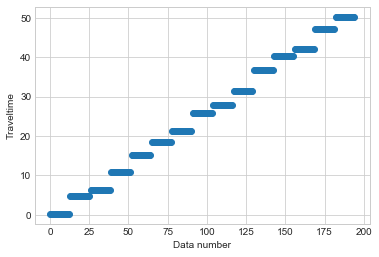

In [8]:
# call the actual raytracing method

tt = g.raytrace(slowness, src, rcv_data)

plt.plot(tt,'o')
plt.xlabel('Data number')
plt.ylabel('Traveltime')
plt.show()

Add some noise to the data

In [9]:
noise_variance = 1.e-3;  # 1 ms
tt += noise_variance*np.random.randn(tt.size)

Combine the event IDs, travel times, and receiver locations

In [10]:
data = np.hstack((src[:,0].reshape((-1,1)), tt.reshape((-1,1)), ircv_data))

## Initial hypocenter locations

Note that for efficiency reason when computing matrix M, initial hypocenters
should _not_ be equal for any two event, e.g. they shoud all be different.

Here we place the initial coordinates more or less in the center of the grid.

In [11]:
hinit = np.vstack((np.arange(nev),
                   np.linspace(0., 50., nev),
                   150. + 0.1*np.random.randn(nev),
                   150. + 0.1*np.random.randn(nev),
                    50. + 0.1*np.random.randn(nev))).T

## Velocity data points

For illustrative purposes, let's add a couple of velocity data points to constrain the inversion

In [12]:
Vpts = np.array([[Vz(1.), 100.0, 100.0, 1.],
                 [Vz(1.), 100.0, 200.0, 1.],
                 [Vz(1.), 200.0, 100.0, 1.],
                 [Vz(1.), 200.0, 200.0, 1.],
                 [Vz(11.), 112.0, 148.0, 11.0],
                 [Vz(5.), 152.0, 108.0, 5.0],
                 [Vz(75.), 152.0, 108.0, 75.0],
                 [Vz(11.), 192.0, 148.0, 11.0]])

## Calibration shots

Let's use 5 shots recorded at most receivers

In [13]:
ncal = 5
src_cal = np.vstack((5+np.arange(ncal),
                 np.zeros(ncal),
                 160. +  5.*np.random.randn(ncal),
                 130. +  5.*np.random.randn(ncal),
                  45. +  5.*np.random.randn(ncal))).T

src_cal = np.kron(src_cal,np.ones((nsta,1)))
rcv_cal = np.kron(np.ones((ncal,1)), rcv)
ircv_cal = np.kron(np.ones((ncal,1)), ircv)

ind = np.ones(rcv_cal.shape[0], dtype=bool)
ind[3] = 0
ind[13] = 0
ind[15] = 0
src_cal = src_cal[ind,:]
rcv_cal = rcv_cal[ind,:]
ircv_cal = ircv_cal[ind,:]

tcal = g.raytrace(slowness, src_cal, rcv_cal)
caldata = np.column_stack((src_cal[:,0], tcal, ircv_cal, src_cal[:,2:], np.zeros(tcal.shape)))

## Constant velocity inversion

Before running the joint hypocenter-velocity inversion (JHVI), we use the constant velocity location algorithm.  This will improve convergence of the JHVI.

Initial velocity model is of course homogeneous, we take the mean value of the data points.

In [14]:
Vinit = np.mean(Vpts[:,0])

hinit2, res = hypo.hypoloc(data, rcv, V=Vinit, hinit=hinit, maxit=15, convh=1., verbose=True)


 *** Hypocenter inversion ***

Locating hypocenters no 0
     Converged at iteration 3
Locating hypocenters no 1
     Converged at iteration 3
Locating hypocenters no 2
     Converged at iteration 3
Locating hypocenters no 3
     Converged at iteration 2
Locating hypocenters no 4
     Converged at iteration 3
Locating hypocenters no 5
     Converged at iteration 3
Locating hypocenters no 6
     Converged at iteration 3
Locating hypocenters no 7
     Converged at iteration 3
Locating hypocenters no 8
     Converged at iteration 2
Locating hypocenters no 9
     Converged at iteration 2
Locating hypocenters no 10
     Converged at iteration 2
Locating hypocenters no 11
     Converged at iteration 3
Locating hypocenters no 12
     Converged at iteration 3
Locating hypocenters no 13
     Converged at iteration 3
Locating hypocenters no 14
     Converged at iteration 2

 ** Inversion complete **



Look now at error on hypocenter location

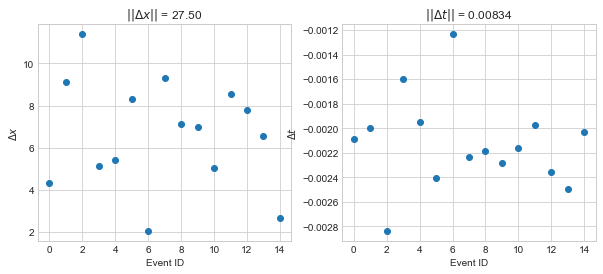

In [15]:
err_x = hinit2[:,2:5] - h_true[:,2:5]
err_x = np.sqrt(np.sum(err_x**2, axis=1))
err_t = hinit2[:,1] - h_true[:,1]

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(err_x,'o')
plt.ylabel(r'$\Delta x$')
plt.xlabel('Event ID')
plt.title(r'$\|\|\Delta x\|\|$ = {0:3.2f}'.format(np.linalg.norm(err_x)))
plt.subplot(122)
plt.plot(err_t,'o')
plt.ylabel(r'$\Delta t$')
plt.xlabel('Event ID')
plt.title(r'$\|\|\Delta t\|\|$ = {0:6.5f}'.format(np.linalg.norm(err_t)))

plt.show()

## Joint hypocenter-velocity inversion parameters

Define inversion parameters

In [16]:
Vpmin = 3500.
Vpmax = 4500.
PAp = 1.0
Vsmin = 1900.
Vsmax = 2300.
PAs = 1.0
Vlim = (Vpmin, Vpmax, PAp, Vsmin, Vsmax, PAs)
        
dVp_max = 100.
dx_max = 10.
dt_max = 0.01
dVs_max = 100.
dmax = (dVp_max, dx_max, dt_max, dVs_max)
        
λ = 2.
γ = 1.
α = 1.
wzK = 0.1
lagran = (λ, γ, α, wzK)

par = hypo.InvParams(maxit=5, maxit_hypo=10, conv_hypo=1., Vlim=Vlim, dmax=dmax,
                     lagrangians=lagran, invert_vel=True, verbose=True)

Let's build an initial velocity model slightly off the true one

In [17]:
def Vz2(z):
    return 4000. + 7.5*(z-50.)

Vpinit = np.kron(Vz2(z), np.ones((g.shape[0], g.shape[1], 1)))
Vpinit = Vpinit.flatten()

## Joint hypocenter-velocity inversion

Run the inversion


 *** Joint hypocenter-velocity inversion ***

Building velocity data point matrix D
Building regularization matrix K

Starting iterations

Iteration 1 - Updating velocity model
                Updating penalty vector
                Raytracing


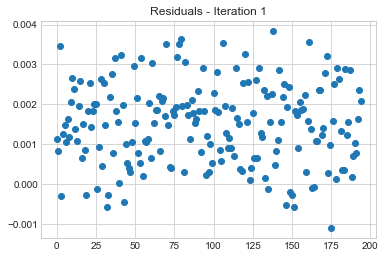

                Building matrix M
                  Event ID 0
                  Event ID 1
                  Event ID 2
                  Event ID 3
                  Event ID 4
                  Event ID 5
                  Event ID 6
                  Event ID 7
                  Event ID 8
                  Event ID 9
                  Event ID 10
                  Event ID 11
                  Event ID 12
                  Event ID 13
                  Event ID 14
                Assembling matrices and solving system
                  calling minres with system of size 14188 x 14188
Iteration 1 - Relocating events
                Updating event ID 0 (1/15)
                  Updating all hypocenter params - converged at iteration 2
                Updating event ID 1 (2/15)
                  Updating all hypocenter params - converged at iteration 2
                Updating event ID 2 (3/15)
                  Updating all hypocenter params - converged at iteration 2
               

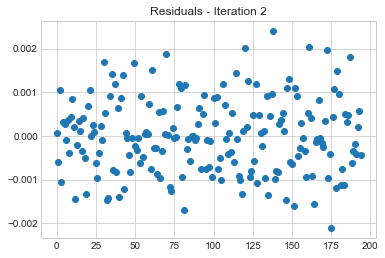

                Building matrix M
                  Event ID 0
                  Event ID 1
                  Event ID 2
                  Event ID 3
                  Event ID 4
                  Event ID 5
                  Event ID 6
                  Event ID 7
                  Event ID 8
                  Event ID 9
                  Event ID 10
                  Event ID 11
                  Event ID 12
                  Event ID 13
                  Event ID 14
                Assembling matrices and solving system
                  calling minres with system of size 14188 x 14188
Iteration 2 - Relocating events
                Updating event ID 0 (1/15)
                  Updating all hypocenter params - converged at iteration 1
                Updating event ID 1 (2/15)
                  Updating all hypocenter params - converged at iteration 1
                Updating event ID 2 (3/15)
                  Updating all hypocenter params - converged at iteration 1
               

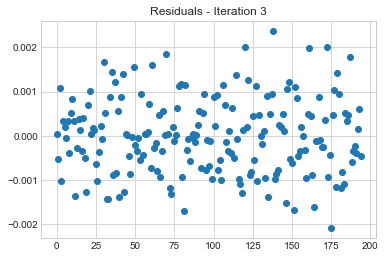

                Building matrix M
                  Event ID 0
                  Event ID 1
                  Event ID 2
                  Event ID 3
                  Event ID 4
                  Event ID 5
                  Event ID 6
                  Event ID 7
                  Event ID 8
                  Event ID 9
                  Event ID 10
                  Event ID 11
                  Event ID 12
                  Event ID 13
                  Event ID 14
                Assembling matrices and solving system
                  calling minres with system of size 14188 x 14188
Iteration 3 - Relocating events
                Updating event ID 0 (1/15)
                  Updating all hypocenter params - converged at iteration 1
                Updating event ID 1 (2/15)
                  Updating all hypocenter params - converged at iteration 1
                Updating event ID 2 (3/15)
                  Updating all hypocenter params - converged at iteration 1
               

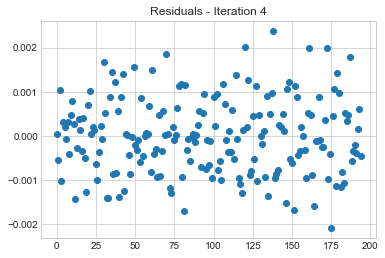

                Building matrix M
                  Event ID 0
                  Event ID 1
                  Event ID 2
                  Event ID 3
                  Event ID 4
                  Event ID 5
                  Event ID 6
                  Event ID 7
                  Event ID 8
                  Event ID 9
                  Event ID 10
                  Event ID 11
                  Event ID 12
                  Event ID 13
                  Event ID 14
                Assembling matrices and solving system
                  calling minres with system of size 14188 x 14188
Iteration 4 - Relocating events
                Updating event ID 0 (1/15)
                  Updating all hypocenter params - converged at iteration 1
                Updating event ID 1 (2/15)
                  Updating all hypocenter params - converged at iteration 1
                Updating event ID 2 (3/15)
                  Updating all hypocenter params - converged at iteration 1
               

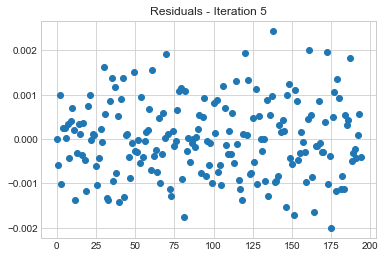

                Building matrix M
                  Event ID 0
                  Event ID 1
                  Event ID 2
                  Event ID 3
                  Event ID 4
                  Event ID 5
                  Event ID 6
                  Event ID 7
                  Event ID 8
                  Event ID 9
                  Event ID 10
                  Event ID 11
                  Event ID 12
                  Event ID 13
                  Event ID 14
                Assembling matrices and solving system
                  calling minres with system of size 14188 x 14188
Iteration 5 - Relocating events
                Updating event ID 0 (1/15)
                  Updating all hypocenter params - converged at iteration 1
                Updating event ID 1 (2/15)
                  Updating all hypocenter params - converged at iteration 1
                Updating event ID 2 (3/15)
                  Updating all hypocenter params - converged at iteration 1
               

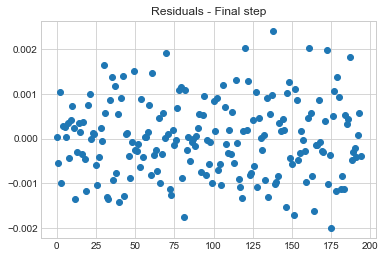


 ** Inversion complete **



In [18]:
h, V, sc, res = hypo.jointHypoVel(par, g, data, rcv, Vpinit, hinit2, caldata=caldata, Vpts=Vpts)

## Results

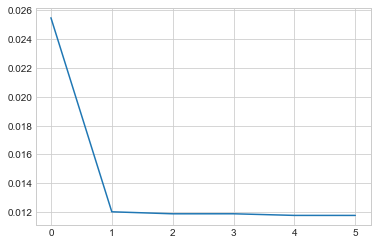

In [19]:
plt.plot(res[0])
plt.show()

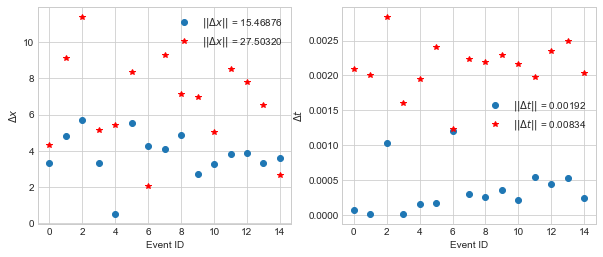

In [20]:
err_xc = hinit2[:,2:5] - h_true[:,2:5]
err_xc = np.sqrt(np.sum(err_xc**2, axis=1))
err_tc = hinit2[:,1] - h_true[:,1]

err_x = h[:,2:5] - h_true[:,2:5]
err_x = np.sqrt(np.sum(err_x**2, axis=1))
err_t = h[:,1] - h_true[:,1]

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(err_x,'o',label=r'$\|\|\Delta x\|\|$ = {0:6.5f}'.format(np.linalg.norm(err_x)))
plt.plot(err_xc,'r*',label=r'$\|\|\Delta x\|\|$ = {0:6.5f}'.format(np.linalg.norm(err_xc)))
plt.ylabel(r'$\Delta x$')
plt.xlabel('Event ID')
plt.legend()
plt.subplot(122)
plt.plot(np.abs(err_t),'o',label=r'$\|\|\Delta t\|\|$ = {0:6.5f}'.format(np.linalg.norm(err_t)))
plt.plot(np.abs(err_tc),'r*',label=r'$\|\|\Delta t\|\|$ = {0:6.5f}'.format(np.linalg.norm(err_tc)))
plt.ylabel(r'$\Delta t$')
plt.xlabel('Event ID')
plt.legend()

plt.show()

We can see a good improvement on relocation over constant velocity inversion.  What about the velocity model?

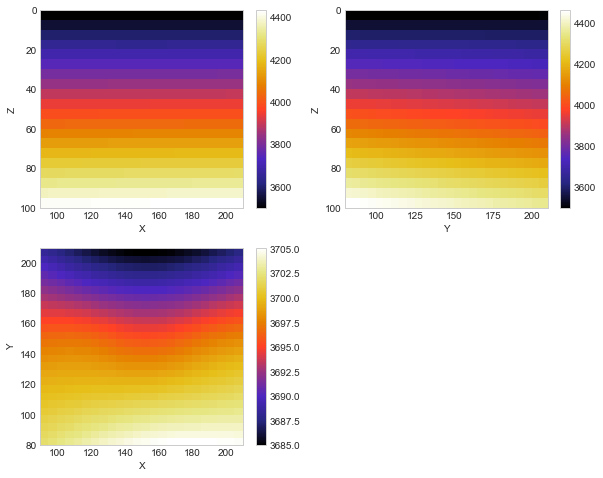

In [21]:
V3d = V.reshape(g.shape)

plt.figure(figsize=(10,8))
plt.subplot(221)
plt.pcolor(x,z,np.squeeze(V3d[:,9,:].T), cmap='CMRmap',), plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Z')
plt.colorbar()
plt.subplot(222)
plt.pcolor(y,z,np.squeeze(V3d[8,:,:].T), cmap='CMRmap'), plt.gca().invert_yaxis()
plt.xlabel('Y')
plt.ylabel('Z')
plt.colorbar()
plt.subplot(223)
plt.pcolor(x,y,np.squeeze(V3d[:,:,4].T), cmap='CMRmap')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()

plt.show()

Let's look at station corrections

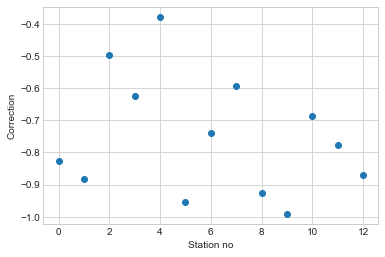

In [22]:
plt.plot(sc,'o')
plt.xlabel('Station no')
plt.ylabel('Correction')
plt.show()